In [1]:
import cv2
from matplotlib.pyplot import imshow
import torch
import numpy as np
import time
import torchvision.transforms as transforms
from PIL import Image

In [17]:
def preprocess_image(image):
        image = Image.fromarray(image)
        normalize = transforms.Normalize(
        mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]
         )
        preprocess = transforms.Compose([
            transforms.Resize((480, 640)),
            transforms.ToTensor(),
            normalize
        ])
        
        return preprocess(image).unsqueeze(0)

In [13]:
def test():
    model = torch.hub.load('hustvl/yolop', 'yolop', pretrained=True)
    vid = cv2.VideoCapture(0) 
    
    while(True): 
        start_time = time.time()
        
        ret, frame = vid.read() 
        frame = cv2.resize(frame, dsize=(640, 480))
        frame = np.asanyarray(frame)
        img = preprocess_image(frame)
        det_out, da_seg_out,ll_seg_out = model(img)
        
        cv2.imshow('rgb', frame) 
        end_time = time.time()
        print(1/(end_time-start_time))

        if cv2.waitKey(1) & 0xFF == ord('q'): 
            break
    
    vid.release() 
    cv2.destroyAllWindows() 

In [16]:
test()

Using cache found in C:\Users\nasty/.cache\torch\hub\hustvl_yolop_main


RuntimeError: Sizes of tensors must match except in dimension 1. Expected size 24 but got size 23 for tensor number 1 in the list.

In [2]:
import torch.onnx
import onnx
import tensorrt as trt

# Определите модель нейронной сети
class YourModel(torch.nn.Module):
    def __init__(self):
        super(YourModel, self).__init__()
        # Здесь определение слоев вашей нейронной сети

# Создайте экземпляр модели
model = YourModel()

# Загрузите параметры модели из файла .pth
model.load_state_dict(torch.load('путь_к_файлу.pth', map_location=torch.device('cpu')))
model.eval()

# Экспорт модели в формат ONNX
dummy_input = torch.randn(1, 3, 224, 224)  # Пример входных данных
onnx_file_path = 'model.onnx'
torch.onnx.export(model, dummy_input, onnx_file_path, verbose=True)




ModuleNotFoundError: No module named 'onnx'

In [3]:
import torch.onnx
import onnx
import tensorrt as trt
import os
# Компиляция ONNX в TensorRT
TRT_LOGGER = trt.Logger(trt.Logger.WARNING)
with trt.Builder(TRT_LOGGER) as builder, builder.create_network() as network, trt.OnnxParser(network, TRT_LOGGER) as parser:
    builder.max_workspace_size = 1 << 30  # 1GB
    builder.max_batch_size = 1
    # Загрузка ONNX модели
    with open('yolop-320-320.onnx', 'rb') as model_file:
        parser.parse(model_file.read())
    # Компиляция модели
    engine = builder.build_cuda_engine(network)

# Сохранение TensorRT модели на диск
trt_file_path = 'yolop-320-320.trt'
with open(trt_file_path, 'wb') as f:
    f.write(engine.serialize())

ModuleNotFoundError: No module named 'tensorrt'

In [1]:
import RPi.GPIO as GPIO
import time
from threading import Thread

# Pin Definitons:
but_pin = 22  # Board pin 18
steps = 0
speed = 0 

def counter():
    # Pin Setup:
    global steps
    
    print("Starting demo now! Press CTRL+C to exit")
    # GPIO.add_event_detect(but_pin, GPIO.FALLING)
    try:
        while True:
            # print("Waiting for button event")
            GPIO.wait_for_edge(but_pin, GPIO.FALLING)
            # if GPIO.event_detected(but_pin):
            #     print('detected')
            # GPIO.wait_for_edge(but_pin, GPIO.FALLING)
            steps += 1
    finally:
        GPIO.cleanup()  # cleanup all GPIOs

def speedometer():
    dt = 1
    R = 0.01
    global steps
    global speed

    last_x = steps
    while True:
        time.sleep(dt)
        x = steps
        diff = x - last_x
        speed = diff / dt
        last_x = x
        vel = 2 * 3.14 * R * speed
        print(vel, end='\r')

GPIO.setmode(GPIO.BOARD)  # BOARD pin-numbering scheme
GPIO.setup(but_pin, GPIO.IN)  # button pin set as input

speed_thr = Thread(target=speedometer)
count_thr = Thread(target=counter)

count_thr.start()
speed_thr.start()
count_thr.join()
speed_thr.join()


/usr/lib/python3/dist-packages/Jetson/GPIO/gpio.py:383: RuntimeWarning: This channel is already in use, continuing anyway. Use GPIO.setwarnings(False) to disable warnings
  warnings.warn(


Starting demo now! Press CTRL+C to exit


KeyboardInterrupt: 

In [4]:
GPIO.cleanup()

In [10]:
main()

Starting demo now! Press CTRL+C to exit


In [2]:
from jetracer.nvidia_racecar import NvidiaRacecar
import time
import RPi.GPIO as GPIO

car = NvidiaRacecar()


ModuleNotFoundError: No module named 'jetracer'

In [4]:
alph = {
    GPIO.BOARD: 'BOARD',
    GPIO.BCM: 'BCM',
    GPIO.CVM: 'CVM',
    GPIO.TEGRA_SOC: 'TEGRA_SOC'
}

v = GPIO.getmode()
v = alph.get(v, v)
print(v)

TEGRA_SOC


In [ ]:
car.throttle = 0.2
time.sleep(6)
car.throttle = 0.0

In [2]:
import RPi.GPIO as GPIO
import time
from threading import Thread, Event

class WheelCounter:
    def __init__(self, but_pin):
        self.but_pin = but_pin
        self.steps = 0
        self.vel = 0
        self.stop_event = Event()

    def counter(self):
        GPIO.setmode(GPIO.BOARD)
        GPIO.setup(self.but_pin, GPIO.IN)

        try:
            while not self.stop_event.is_set():
                GPIO.wait_for_edge(self.but_pin, GPIO.FALLING)
                self.steps += 1
        finally:
            GPIO.cleanup()

    def speedometer(self):
        dt = 1
        R = 0.01
        last_x = 0
        
        while not self.stop_event.is_set():
            time.sleep(dt)
            x = self.steps
            diff = x - last_x
            speed = diff / dt
            last_x = x
            self.vel = 2 * 3.14 * R * speed
            print(self.vel, end='\r')

    def start(self):
        self.count_thr = Thread(target=self.counter)
        self.speed_thr = Thread(target=self.speedometer)

        self.count_thr.start()
        self.speed_thr.start()

    def stop(self):
        self.stop_event.set()
        self.count_thr.join()
        self.speed_thr.join()

# if __name__ == "__main__":
#     but_pin = 22  # Board pin 18
#     wheel_counter = WheelCounter(but_pin)
#     wheel_counter.start()

#     try:
#         while True:
#             time.sleep(1)
#     except KeyboardInterrupt:
#         wheel_counter.stop()


In [5]:
wc = WheelCounter(22)
wc.start()
wc.vel


/usr/lib/python3/dist-packages/Jetson/GPIO/gpio.py:383: RuntimeWarning: This channel is already in use, continuing anyway. Use GPIO.setwarnings(False) to disable warnings
  warnings.warn(


0

In [1]:
import time
import numpy as np
from scipy.signal import fftconvolve
from matplotlib.pyplot import imshow

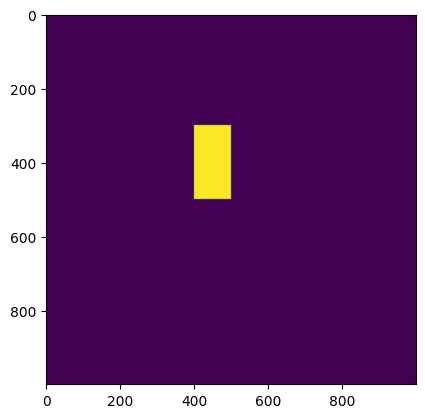

In [2]:
a = np.ones((250,400))
b = np.zeros((1000, 1000))
b[300:500, 400:500] = 255
imshow(b)

In [7]:
t_s = time.time()
c1 = fftconvolve(b, a, mode='same')
# c1[c1>255]=255
# c1 = c1.astype(np.uint8)
time.time() - t_s
# imshow(c1)

0.19545388221740723